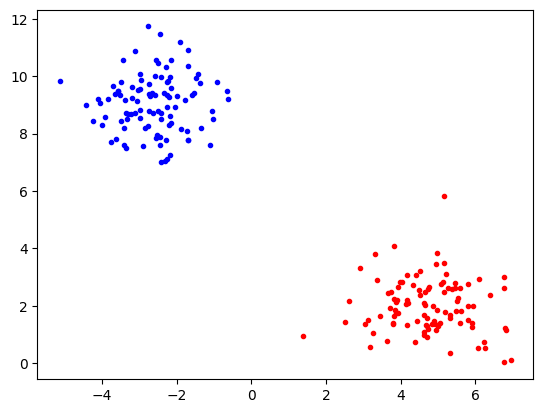

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

np.random.seed(42)

X, y = make_blobs(n_samples=200, centers=2)
idxs_1 = np.argwhere(y==1)
idxs_0 = np.argwhere(y==0)
X1 = X[np.reshape(idxs_1, idxs_1.size)]
X0 = X[np.reshape(idxs_0, idxs_0.size)]

plt.plot(X0[:,0], X0[:,1], 'b.', X1[:,0], X1[:,1], 'r.')
y[y==0] -= 1

In [2]:
class SVM:
    """ 
    A regularized kernel SVM 
    
    ...

    Attributes
    ----------
    C : float
        The inverse regularization parameter
    kernel: str
        The kernel type (e.g. linear, gaussian_rbf, etc..)

    Methods
    -------
    train(X,y):
        Trains the model on the dataset (X,y)

    predict(q):
        Makes a prediction about query point q
    """
    def __init__(self, C, kernel="linear"):
        self.C = C
        self.kernel = kernel
        self.r_idx = 0

    def _compute_w(self, X, y, alpha):
        """ Use representer theorem to retrieve w from alpha """
        N, D = X.shape

        w = np.zeros(D)
        for i in range(N):
            w += alpha[i]*y[i]*X[i]

        return w

    def _compute_b(self, y, w, alpha):
        N = y.size

        # Pick a point on the margin's boundary
        sv_idx = None
        for i in range(N):
            if alpha[i] > 0:
                sv_idx = i
        
        if sv_idx is not None:
            b = w@X[sv_idx] - y[sv_idx]
        else:
            return None, False
        
        return b, True
    
    def _float_equals(self, a, b, tol=1e-6):
        return abs(a - b) < tol

    def _has_converged(self, X, y, alpha, K, eps, j):
        """ Check if alpha values have converged """
        N, D = X.shape
        
        w = self._compute_w(X, y, alpha)
        b, found = self._compute_b(y, w, alpha)
        
        if not found:
            return False, w, b

        u = []
        for i in range(N):
            u_i = 0
            for j in range(N):
                u_i += y[j]*alpha[j]*K[j,i]
            
            u_i -= b
            u.append(u_i)
        
        converged = True
        for i in range(N):
            if alpha[i] == 0: #self._float_equals(alpha[i], 0):
                if not y[i]*u[i] >= 1: #1 - eps:
                    self.r_idx = i
                    converged = False
                    break
            elif alpha[i] == self.C: #self._float_equals(alpha[i], self.C):
                if not y[i]*u[i] <= 1: #1 - eps:
                    self.r_idx = i
                    converged = False
                    break
            else:
                if not self._float_equals((y[i]*u[i]).item(), 1, tol=eps):
                    self.r_idx = i
                    converged = False
                    break
                
        return converged, w, b
    
    def train(self, X, y):
        """ Train the classifier using the SMO algorithm """
        N, D = X.shape

        # Picking feasible alpha
        alpha = np.zeros(N)
        eps = 1e-3
        converged = False

        # Compute Kernel
        if self.kernel == "gaussian":
            K = self.compute_gaussian_kernel(X)
        else:
            K = self.compute_linear_kernel(X)

        i = 1 # use i (as idx of s) and i-1 (as idx of r) as alpha idxs
        num_iters = 0
        while not converged:
            masked_alpha = np.copy(alpha)
            r = random.randrange(0, 200) #self.r_idx # was i-1
            s = None
            
            while s is None:
                s = random.randrange(0, 200)
                if s == r:
                    s = None

            # Zero out alpha_r and alpha_s to vectorize
            masked_alpha[r] = 0
            masked_alpha[s] = 0
            zeta = -masked_alpha@y

            # Coefficient a of the quadratic expression in alpha_r
            a = -(1/2)*(y[r]**2*K[r,r]+y[r]**2*K[s,s]-2*y[r]**2*K[r,s])

            # Coefficient b of the quadratic expression in alpha_r
            sum = 0
            for j in range(N):
                if j == s or j == r:
                    continue

                sum += masked_alpha[j]*y[j]*(K[s,j]-K[r,j])
                
            b = 1-(1/y[s])*y[r]+zeta*y[r]*(K[s,s]-K[r,s])+(1/2)*y[r]*sum

            endpoint1 = max(0, -y[r]*(y[s]*self.C-zeta)) if y[r] == y[s] else max(0, y[r]*zeta)
            endpoint2 = min(self.C, y[r]*zeta) if y[r] == y[s] else min(self.C, -y[r]*(y[s]*self.C-zeta)) 
            if a != 0:
                proposed_alpha_r = max(endpoint1, -b/(2*a), endpoint2)
            else:
                proposed_alpha_r = max(endpoint1, endpoint2)
                
            proposed_alpha_s = (1/y[s])*(zeta - y[r]*proposed_alpha_r)

            # Check if constraints are satisfied
            feasible = False
            masked_alpha[r] = proposed_alpha_r
            masked_alpha[s] = proposed_alpha_s
            
            constraint_a = self._float_equals(masked_alpha@y, 0)
            mask = np.logical_and(masked_alpha <= self.C, masked_alpha >= 0)
            constraint_b = np.sum(mask.astype(np.int8)) == N

            feasible = constraint_a and constraint_b
            
            if feasible:
                alpha[r] = proposed_alpha_r
                alpha[s] = proposed_alpha_s

            #if not np.array_equal(alpha, np.zeros_like(alpha)):
            converged, w, b = self._has_converged(X, y, alpha, K, eps, i)

            if converged:
                self.w = w
                self.b = b
            
            i += 1
            if i >= N:
                num_iters += 1
                print(np.linalg.norm(alpha))
                print(f"r_idx is: {self.r_idx}")
                print(f"===> with value {alpha[self.r_idx]}")
                print(f"===> with functional margin {y[self.r_idx]*(w@X[self.r_idx] + b)}")
                print(f"===> and y[r_idx] is {y[self.r_idx]}\n")
                i = i % N

    def compute_gaussian_kernel(self, X, sigma=1.0):
        N, D = X.shape
        
        K = np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                K[i,j] = np.exp(-(X[i]-X[j])@(X[i]-X[j])/(2*sigma**2))
                
        return K

    def compute_linear_kernel(self, X):
        return X@X.T

    def predict(self, q):
        return 1 if self.w@q + self.b >= 0 else -1

In [3]:
C = 1

def normalize(X):
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

X_tilde = normalize(X)

svm = SVM(C, kernel="linear")
svm.train(X, y.astype('float64'))

10.099504938362077
r_idx is: 0
===> with value 1.0
===> with functional margin -3499.1031771295993
===> and y[r_idx] is 1.0

11.832159566199232
r_idx is: 0
===> with value 1.0
===> with functional margin -4812.05989703004
===> and y[r_idx] is 1.0

12.96148139681572
r_idx is: 1
===> with value 1.0
===> with functional margin -4416.654259377427
===> and y[r_idx] is 1.0

13.114877048604
r_idx is: 1
===> with value 1.0
===> with functional margin -4530.67695785859
===> and y[r_idx] is 1.0

13.19090595827292
r_idx is: 1
===> with value 1.0
===> with functional margin -4599.614265254728
===> and y[r_idx] is 1.0

13.2664991614216
r_idx is: 1
===> with value 1.0
===> with functional margin -4626.69963151869
===> and y[r_idx] is 1.0

13.490737563232042
r_idx is: 1
===> with value 1.0
===> with functional margin -4744.760033272058
===> and y[r_idx] is 1.0

13.564659966250536
r_idx is: 1
===> with value 1.0
===> with functional margin -4797.940390460021
===> and y[r_idx] is 1.0

13.56465996625053

KeyboardInterrupt: 

In [ ]:
plt.plot(X0[:,0], X0[:,1], 'b.', X1[:,0], X1[:,1], 'r.')
svm.predict(np.array([-4, 6]))

prediction_grid = np.zeros((200, 200))

x = np.linspace(-6, 8, 200)
y = np.linspace(-1, 12, 200)

xv, yv = np.meshgrid(x, y, indexing='xy')
for i in range(200):
    for j in range(200):
        prediction_grid[i,j] = svm.predict(np.array([xv[j,i], yv[j,i]]))

plt.figure()
plt.imshow(prediction_grid)